In [1]:
pip install pandas


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from random import randint
from torchvision.transforms import Resize
from torch.utils.data import random_split
from PIL import Image
from torchvision import transforms
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
        self.act1  = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = nn.Linear(53664, 256)
        self.act3  = nn.ReLU()
        
        self.fc2   = nn.Linear(256, 64)
        self.act4  = nn.Tanh()
        
        self.fc3   = nn.Linear(64, 28)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [3]:
net = Net()

In [4]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        full_list = list(Path(img_dir).glob("*.jpg"))
        self.images = full_list[:512]
        
        app_labels = pd.read_csv('app_details.csv')
        # ui_labels = pd.read_csv('ui_details.csv')
        labels = app_labels.Category.astype('category').cat.codes
        self.labels = list(labels)
        
        # categories = set()
        # for element in self.labels:
        # categories.add(element)
        # print(len(categories))
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((180, 320))])
        image = transform(image)
        label = int(self.labels[idx])
        return image, label

In [6]:
pathname = "unique_uis/combined"
ds = CustomImageDataset(pathname)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train, test = random_split(ds, [train_size, test_size])

train_loader = DataLoader(train, batch_size=2, shuffle=True)

test_loader = DataLoader(test, batch_size=2, shuffle=False)

In [7]:
net.train()
list_of_losses = []

for epoch_index in range(3):
    for batch, label in train_loader:
        optimizer.zero_grad()
        pred = net(batch)
        loss_val = loss(pred, label)
        list_of_losses.append(loss_val.data.cpu())
        loss_val.backward()
        optimizer.step()
        
print("ended")

/home/drocher228/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


ended


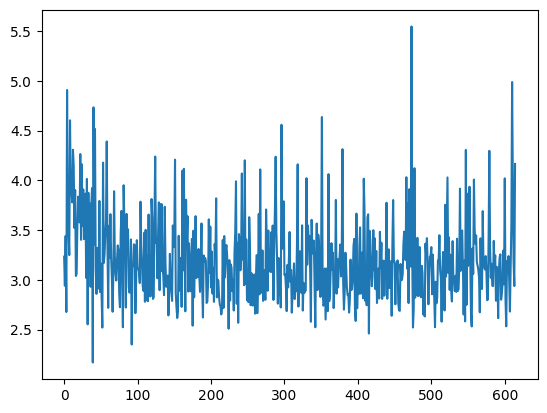

In [8]:
numbers = []
for i in range(len(list_of_losses)):
    numbers.append(i)
plt.plot(numbers, list_of_losses)